<a href="https://colab.research.google.com/github/karthikeyansura/credit-approval-prediction/blob/main/MidTerm-ML.SuraS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview**

This project presents the end-to-end development of a machine learning model to predict loan approval outcomes based on applicant and loan characteristics. Using a real-world dataset of approximately **45,000 loan applications**, the project implements and compares three supervised classification algorithms (**Logistic Regression**, **Random Forest**, and **XGBoost**) to automate the loan screening process. The workflow includes comprehensive data preprocessing, feature selection, model training, and hyperparameter tuning using `GridSearchCV`. The final tuned **XGBoost** model achieved an **F1-Score of 0.8356**, demonstrating both accuracy and generalization.

# **Problem statement**

Financial institutions face increasing challenges in assessing loan applications accurately and efficiently. Traditional manual reviews are **time-consuming**, and often **inconsistent**, leading to:

- Approval of risky applications.
- Rejection of creditworthy applicants.
- Delayed processing times and reduced customer satisfaction.

Additionally, datasets present multiple challenges such as:

- **Class imbalance:** 3.50:1 ratio of “Not Approved” to “Approved” applications.
- **Data quality issues:** Presence of invalid outliers and severe multicollinearity.
- **Mixed feature types:** Combination of numerical, categorical, and ordinal data requiring proper encoding and scaling.

This project addresses these issues through a systematic and reproducible machine learning pipeline to improve both the **accuracy** and **efficiency** of loan approval decisions.


# **Objective**

The objective is to develop a robust and interpretable classification model that predicts **loan approval status** with high accuracy and fairness.  

- **Build three supervised classification models** - Logistic Regression, Random Forest, and XGBoost to compare performance.  
- **Perform rigorous preprocessing**, including cleaning outliers, encoding categorical variables, and scaling numerical features.  
- **Handle class imbalance** effectively using `class_weight='balanced'` (for LR and RF) and `scale_pos_weight` (for XGBoost).  
- **Select key predictive features** using Recursive Feature Elimination (RFE) to improve model interpretability.
- **Tune hyperparameters systematically** using `GridSearchCV` with 5-fold cross-validation to maximize the **F1-Score**.  
- **Evaluate model performance** using multiple metrics (Accuracy, Precision, Recall, F1-Score, and ROC-AUC) for a complete assessment.

# **Introduction**

In modern banking systems, accurate and timely loan approval decisions are crucial for both **risk management** and **customer satisfaction**. Manual assessment of thousands of applications is inefficient, error-prone, and susceptible to human bias. Machine learning offers a data-driven solution that can analyze complex interactions among financial and demographic variables to make reliable predictions in seconds.

This project applies **classification supervised learning** techniques to automate the loan approval process using a dataset containing key attributes such as income, credit score, employment experience, and loan-to-income ratio. The pipeline involves:

- **Data preprocessing:** Cleaning outliers, handling missing values, and resolving multicollinearity.
- **Feature engineering:** Selecting the 12 most informative predictors via RFE.
- **Model training and evaluation:** Building three classifiers and comparing their baseline and tuned performance.
- **Hyperparameter tuning:** Using `GridSearchCV` for systematic optimization.
- **Interpretation and validation:** Evaluating using multiple performance metrics and cross-validation.

By implementing this workflow, the system achieved both **high predictive accuracy (92.67%)** and **operational efficiency**, reducing manual review workload while maintaining fairness and consistency. The results demonstrate that **XGBoost** is the optimal choice for deployment, offering superior precision-recall balance and robust performance on unseen data.

# **Initial set-up**

In [ ]:
# Import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV

# Cross validation
from sklearn.model_selection import cross_validate

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from sklearn.model_selection import cross_val_score

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset into a dataframe
file_path = "/content/loan_data.csv"
df = pd.read_csv(file_path)

# **1) What dataset did you use? How many samples? Labeled? Unlabeled? Features?**

Sample of the dataset:


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1



Number of records: 45000

Number of feautures: 14

Data types and feature analysis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_s

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00



Class distribution (loan_status):
loan_status
0    35000
1    10000
Name: count, dtype: int64


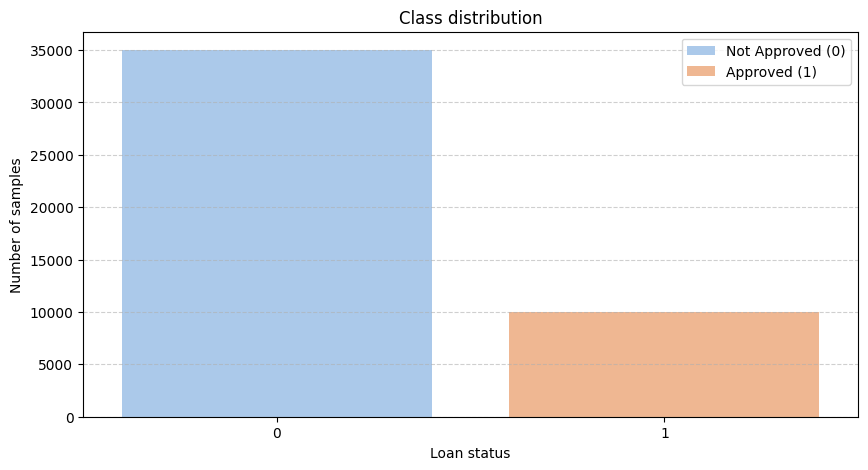


Countplots of each categorical feature against target variable:


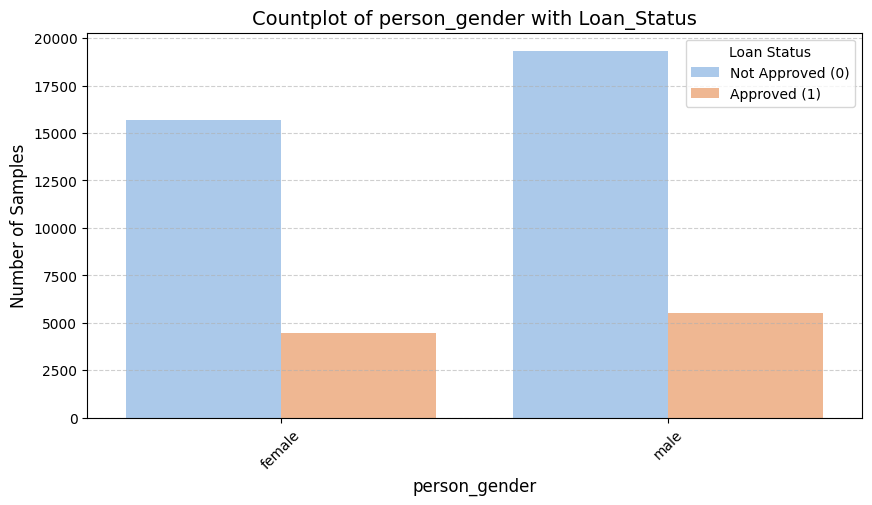

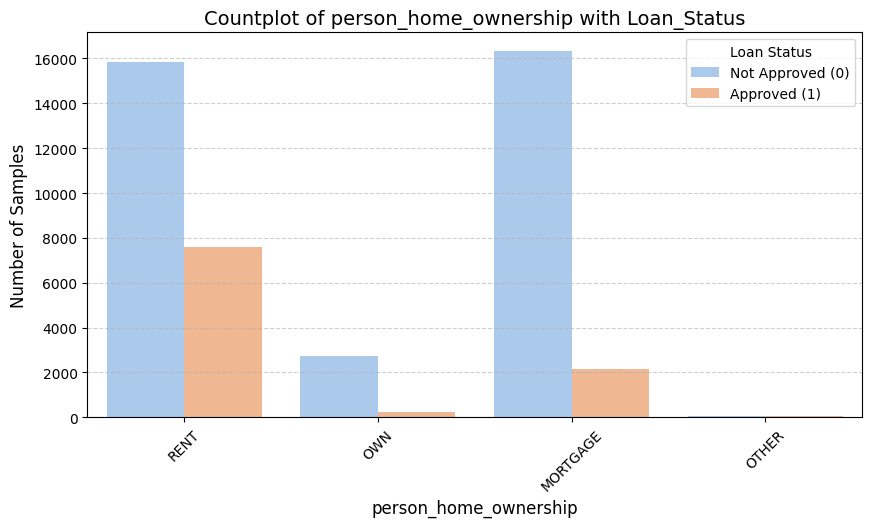

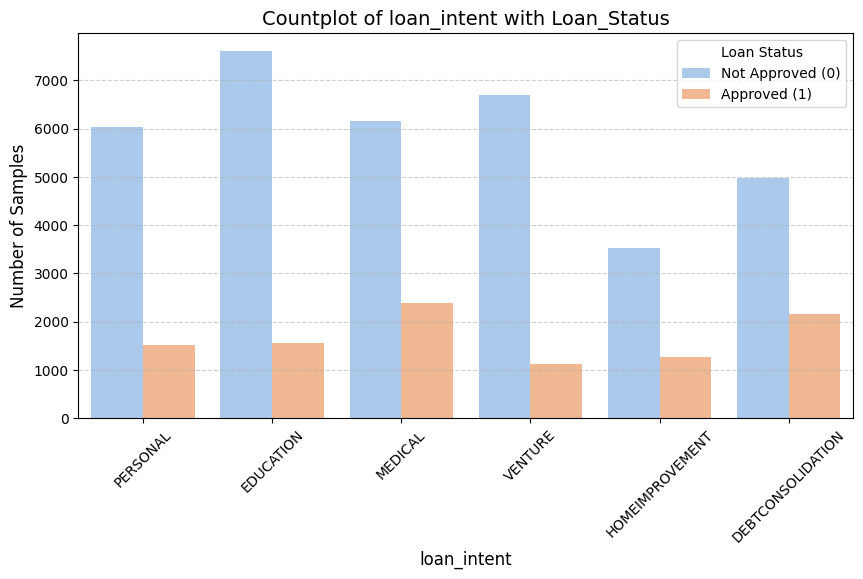

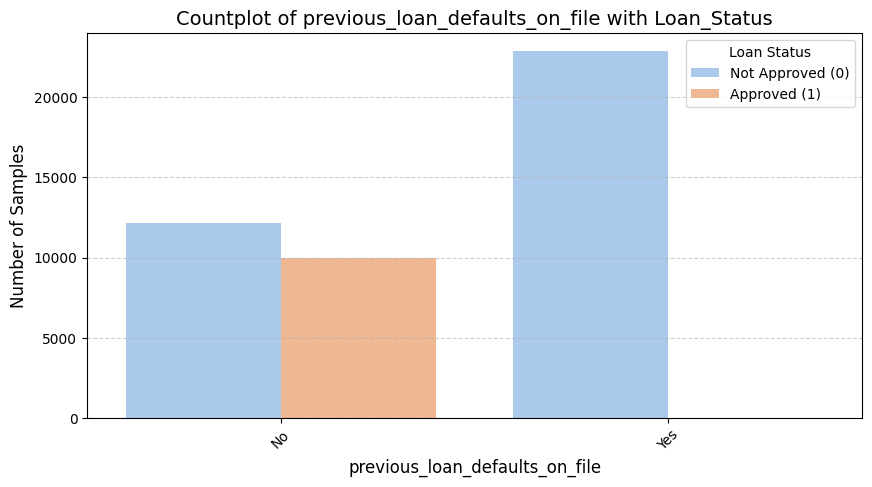

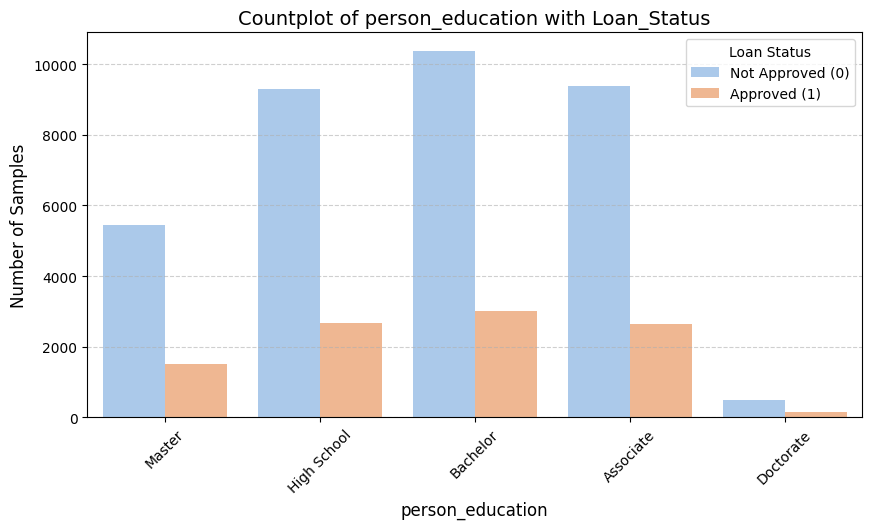

In [ ]:
# Displays a sample of the dataset
print("Sample of the dataset:")
display(df.head())

# Computes the shape of the dataset
print(f"\nNumber of records: {df.shape[0]}")
print(f"\nNumber of feautures: {df.shape[1]}")

# Data types and feature analysis
print("\nData types and feature analysis:")
df.info()

# Number of unique values in each feature to identify categorical variables.
print("\nUnique value count for each feature:")
print(df.nunique())

# Statistical description
print("\nStatistical description:")
display(df.describe().T)

# Target variable class distribution
print("\nClass distribution (loan_status):")
print(df['loan_status'].value_counts())
# Plot for class distribution visualization
plt.figure(figsize=(10,5))
sns.countplot(x='loan_status', data=df, palette='pastel')
plt.title('Class distribution')
plt.xlabel('Loan status')
plt.ylabel('Number of samples')
plt.legend(labels=['Not Approved (0)', 'Approved (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print("\nCountplots of each categorical feature against target variable:")
# Load categorical features to create countplots of each categorical feature with respect to target variable
cat_cols = ['person_gender', 'person_home_ownership', 'loan_intent',
            'previous_loan_defaults_on_file', 'person_education']
# Countplots of each categorical feature against loan_status
for col in cat_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x=col, hue='loan_status', palette='pastel')
    plt.title(f'Countplot of {col} with Loan_Status', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.legend(title='Loan Status', labels=['Not Approved (0)', 'Approved (1)'])
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


## **a. What type of data, and what is your data about?**

This is a **structured, tabular dataset** containing information about loan applications and their approval status. The dataset includes:

- **Applicant demographics:** Age, gender, education level
- **Financial information:** Income, employment experience, Home Ownership
- **Loan details:** Loan amount, intended use, Loan-to-Income Ratio, interest rate
- **Credit history:** Credit history length, Credit Score, Previous Loan Defaults
- **Target variable:** loan approval status

The goal is to predict loan approval status based on these features.

## **b. If it is labeled, how many samples do you have in minority and majority class of the data?**

The dataset is labeled with the target variable **loan_status**, which indicates whether the loan was approved (`1`) or not (`0`).

- **Majority class (0):** 35,000 samples (77.78 %)
- **Minority class (1):** 10,000 samples (22.22 %)

The dataset is moderately imbalanced, with a lower number of approved loans.

## **c. Provide a brief description of the features, and a link to the data.**

**Data link:** [https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data](https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data)

The dataset has 14 attributes which includes 13 features and 1 target variable:

| Attribute | Description |
|------------|-------------|
| person_age | Age of the individual |
| person_gender | Gender identification of the individual |
| person_education | Level of education attained by the person |
| person_income | Yearly income of the individual |
| person_emp_exp | Total years of work experience the individual has |
| person_home_ownership | Current home ownership status (e.g., renting, owned, mortgaged) |
| loan_amnt | Amount of loan the individual has requested |
| loan_intent | Intended use for the loan (e.g., home purchase, consolidation) |
| loan_int_rate | Interest rate applied to the loan |
| loan_percent_income | Ratio of loan amount to the person's annual income |
| cb_person_cred_hist_length | Duration of the individual's credit history in years |
| credit_score | Numeric score representing the individual's creditworthiness |
| previous_loan_defaults_on_file | Indicator of any prior loan defaults in the person's history |
| loan_status (target variable) | Loan approval result: 1 = approved, 0 = rejected |

## **d. Analyze your data, any categorical, ordinal, and etc?**

The dataset contains a mix of categorical, ordinal, and numerical features. Categorical features represent qualitative attributes, numerical features capture measurable quantities, and ordinal features indicate a natural order among categories.

- **Categorical Features**
  - *person_gender:* Gender of the applicant (Nominal)  
  - *person_home_ownership:* Type of home ownership (Nominal)  
  - *loan_intent:* Purpose or intended use of the loan (Nominal)  
  - *previous_loan_defaults_on_file:* History of any prior loan defaults (Nominal)  
  - *loan_status:* Target variable indicating loan approval (Binary)

- **Ordinal Feature**
  - *person_education:* Highest education level attained by the applicant, with a natural order (High School < Bachelor < Master)

- **Numerical Features**
  - *person_age:* Age of the applicant in years (Continuous)  
  - *person_income:* Annual income in USD (Continuous)  
  - *person_emp_exp:* Total years of employment experience (Discrete)  
  - *loan_amnt:* Amount of loan requested in USD (Continuous)  
  - *loan_int_rate:* Interest rate applied to the loan (Continuous)  
  - *loan_percent_income:* Loan amount as a fraction of income (Continuous)  
  - *cb_person_cred_hist_length:* Length of applicant’s credit history in years (Continuous)  
  - *credit_score:* Numeric score representing creditworthiness (Discrete)

  Overall, the dataset includes both **quantitative** (numerical) and **qualitative** (categorical) variables.

# **2) Use data pre-processing? EDA? Feature engineering.**

Missing values per feature:
person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

Duplicate rows:
0

Number of outliers (IQR):
person_age                -  2188 ( 4.86%)
person_income             -  2218 ( 4.93%)
person_emp_exp            -  1724 ( 3.83%)
loan_amnt                 -  2348 ( 5.22%)
loan_int_rate             -   124 ( 0.28%)
loan_percent_income       -   744 ( 1.65%)
cb_person_cred_hist_length -  1366 ( 3.04%)
credit_score              -   467 ( 1.04%)

Box plots:


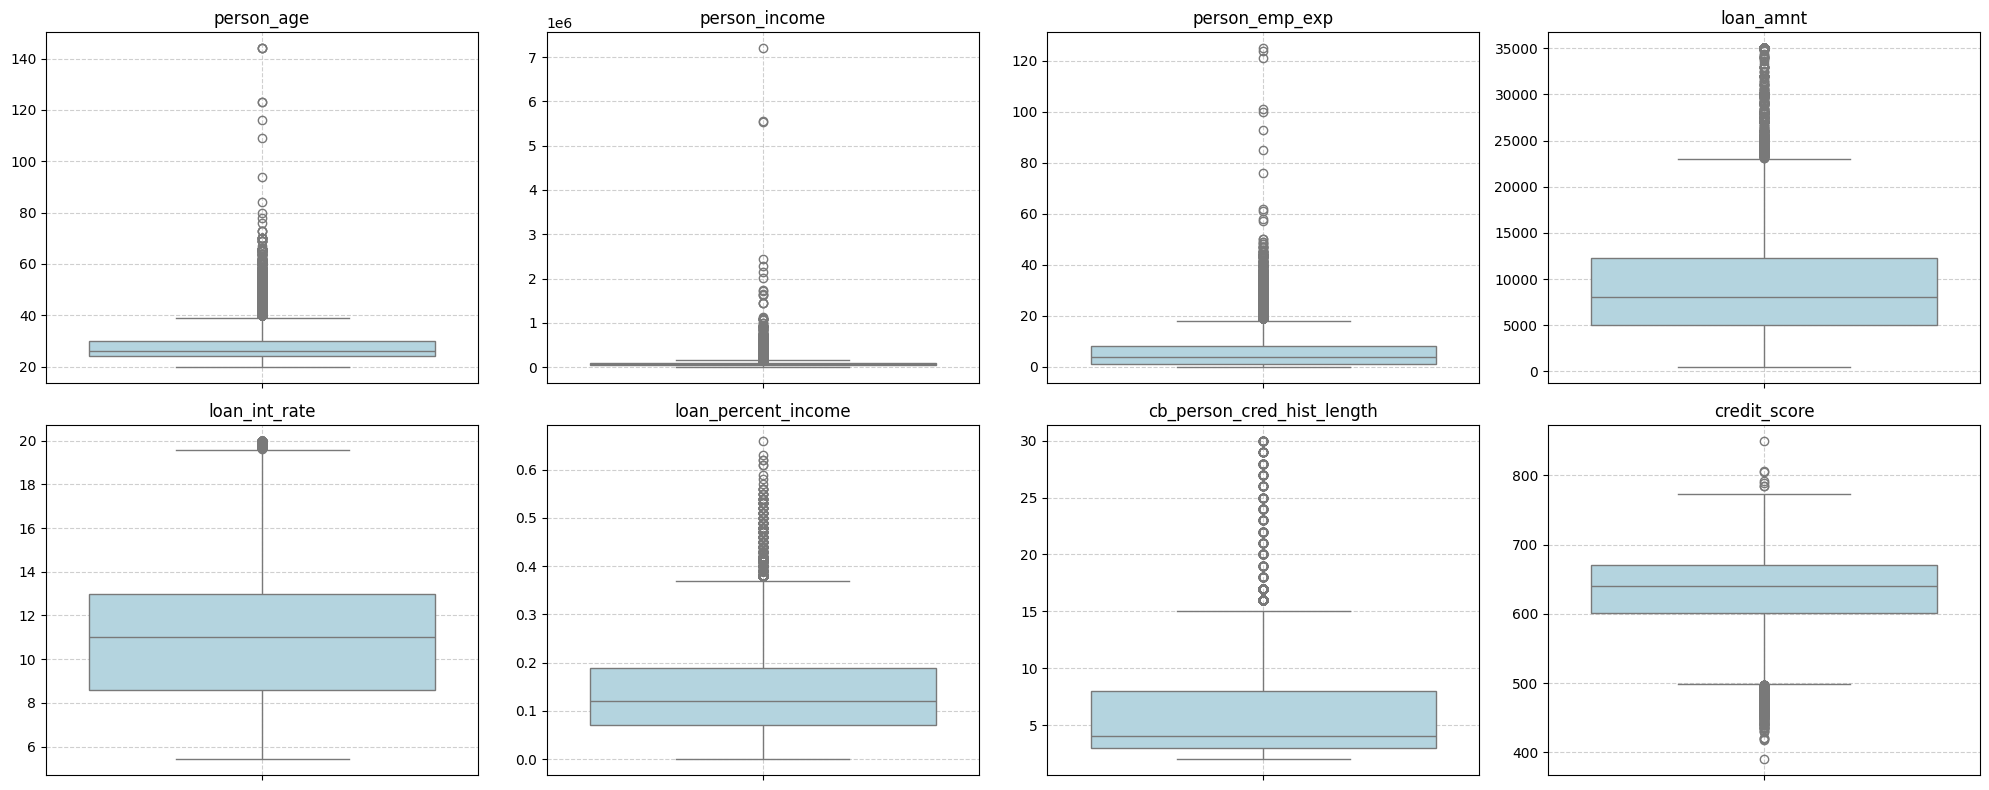


Number of samples after handling: 44992

Number of outliers after handling (IQR):
person_age                -  2180 ( 4.85%)
person_income             -  2214 ( 4.92%)
person_emp_exp            -  1716 ( 3.81%)
loan_amnt                 -  2348 ( 5.22%)
loan_int_rate             -   124 ( 0.28%)
loan_percent_income       -   744 ( 1.65%)
cb_person_cred_hist_length -  1362 ( 3.03%)
credit_score              -   462 ( 1.03%)

Box plots after outlier handling:


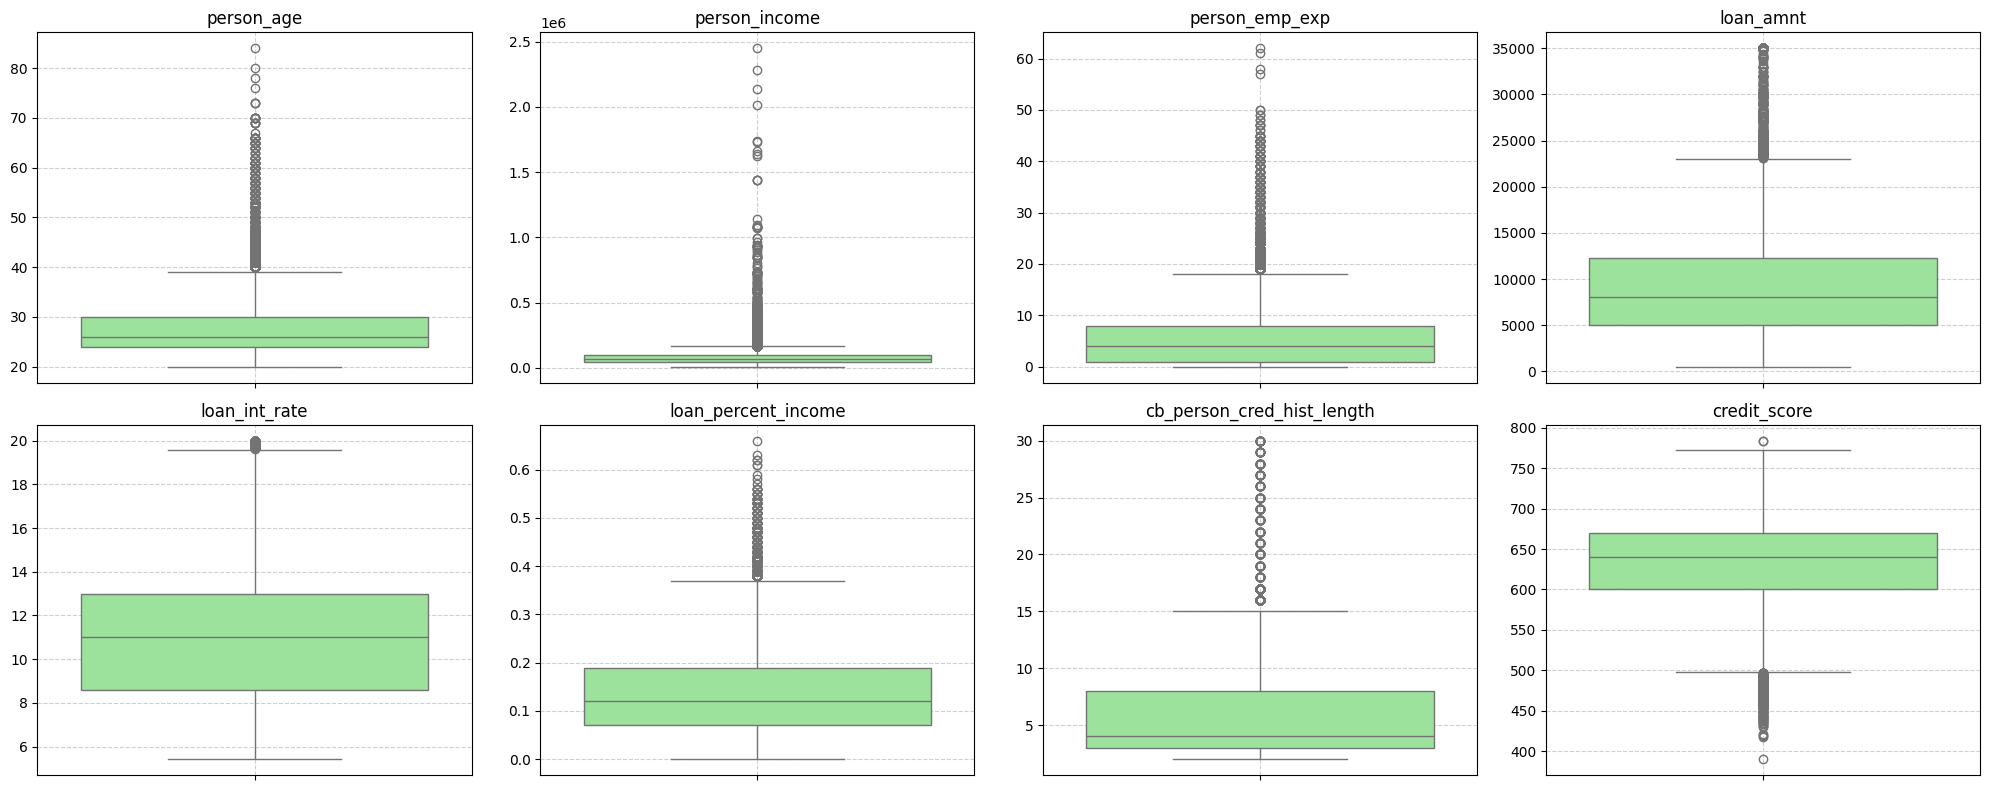

In [ ]:
# Data pre-processing
# Check for any missing values, if present display number of missing values per feature
print("Missing values per feature:")
print(df.isna().sum())

# Check for any duplicate rows, if present display number of duplication rows
print("\nDuplicate rows:")
print(df.duplicated().sum())

# Load attributes that are numerical to check for any possible outliers
numerical_vars = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

# Outlier detection using IQR method
print("\nNumber of outliers (IQR):")
for var in numerical_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(f"{var:<25} - {len(outliers):>5} ({len(outliers)/len(df)*100:5.2f}%)")

# Box plots to visually validate outliers presence
print("\nBox plots:")
n_cols = 4
n_rows = int(np.ceil(len(numerical_vars) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()
for i, var in enumerate(numerical_vars):
    sns.boxplot(y=df[var], ax=axes[i], color="lightblue")
    axes[i].set_title(var, fontsize=12)
    axes[i].set_ylabel("")
    axes[i].grid(True, linestyle='--', alpha=0.6)
# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Handle unrealistic values
df = df[(df['person_age'] <= 100) & (df['person_emp_exp'] <= 65)]

# Number of samples after handling unrealistic values
print("\nNumber of samples after handling:", df.shape[0])

# Outlier detection after handling using IQR method
print("\nNumber of outliers after handling (IQR):")
for var in numerical_vars:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    print(f"{var:<25} - {len(outliers):>5} ({len(outliers)/len(df)*100:5.2f}%)")

# Box plots after outlier handling
print("\nBox plots after outlier handling:")
n_cols = 4
n_rows = int(np.ceil(len(numerical_vars) / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows*4))
axes = axes.flatten()
for i, var in enumerate(numerical_vars):
    sns.boxplot(y=df[var], ax=axes[i], color="lightgreen")
    axes[i].set_title(var, fontsize=12)
    axes[i].set_ylabel("")
    axes[i].grid(True, linestyle='--', alpha=0.6)
# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Distribution plots for numerical variables:


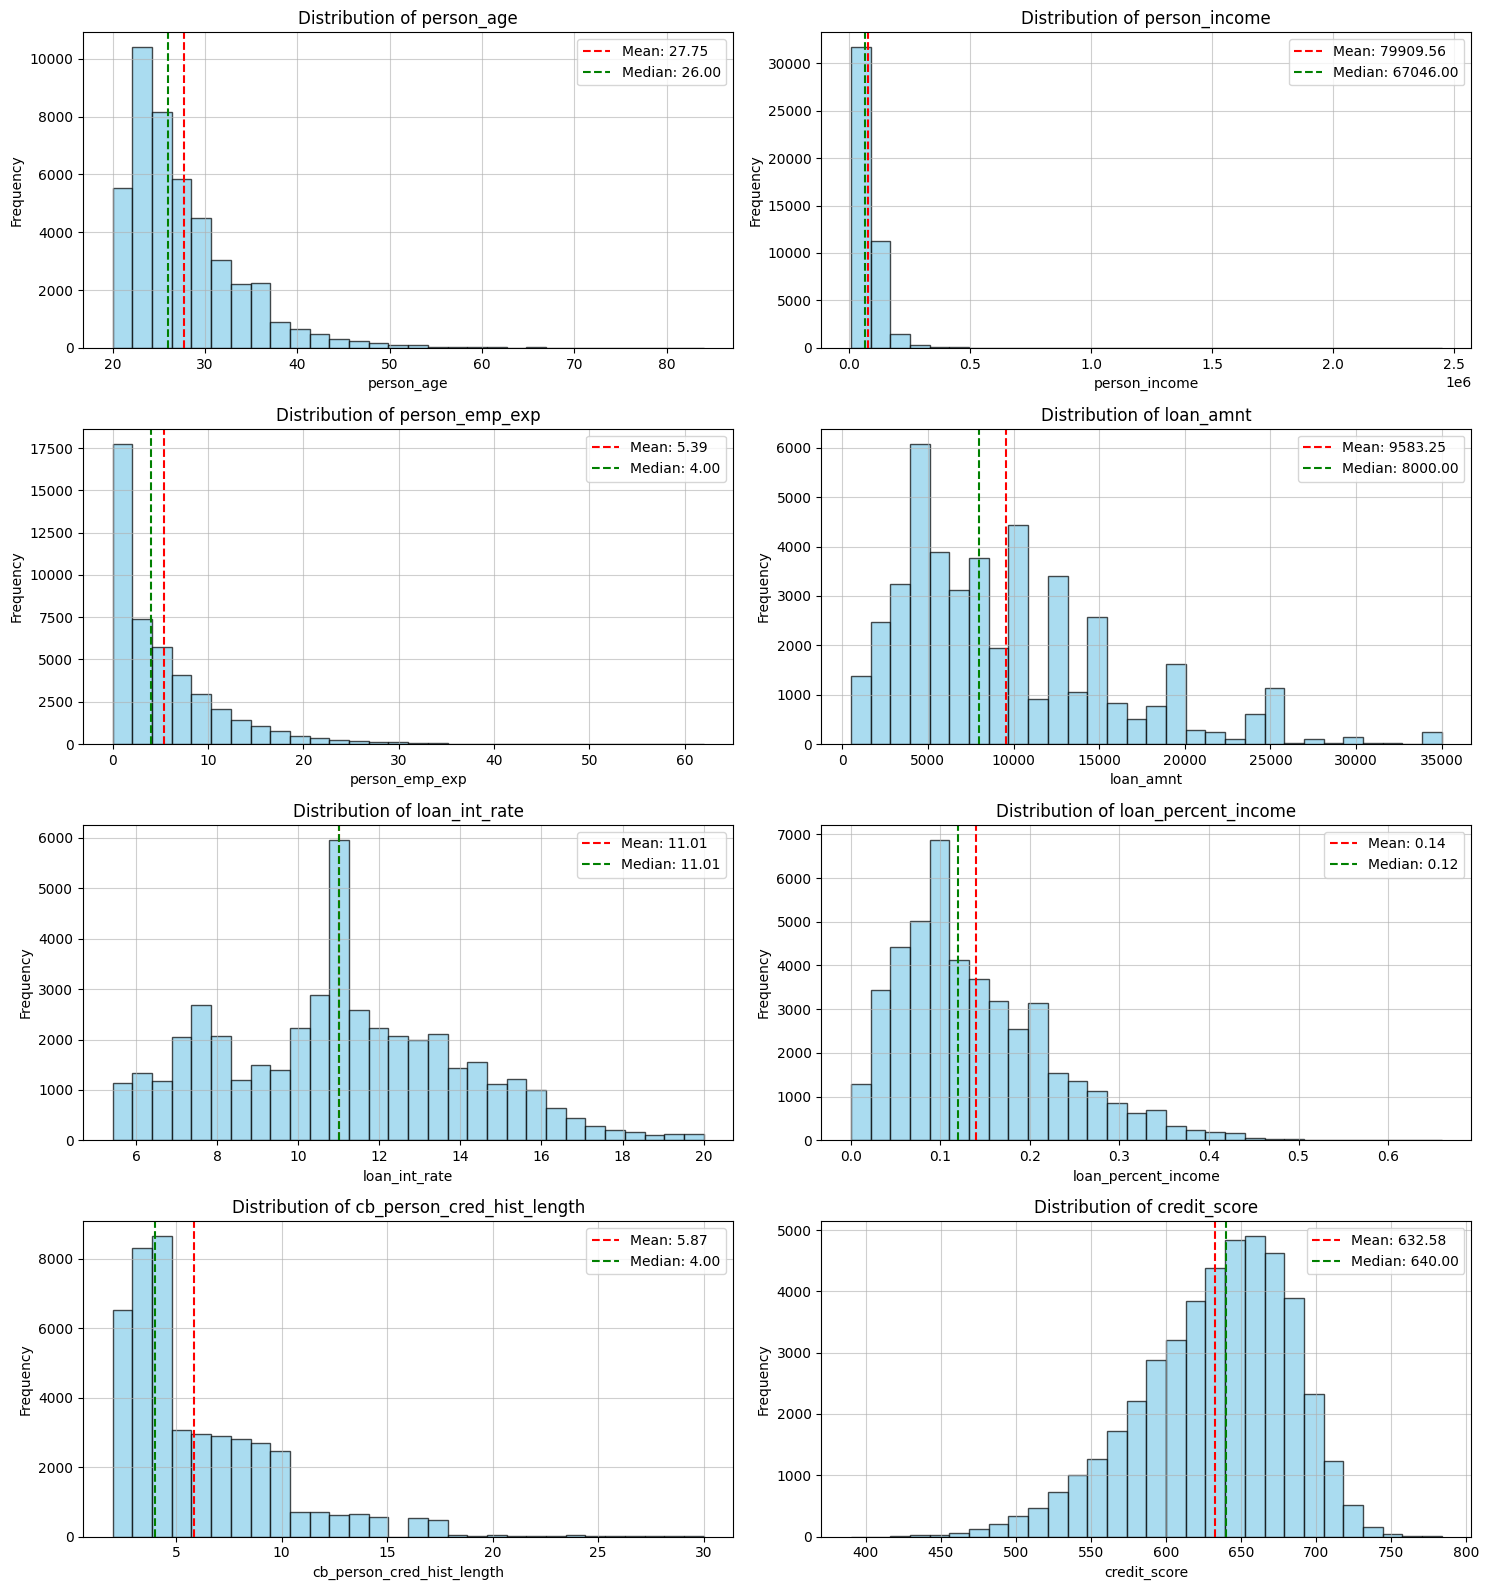


Skewness Analysis:
person_age                    :   1.888 - Right-skewed (positive)
person_income                 :   9.695 - Right-skewed (positive)
person_emp_exp                :   1.924 - Right-skewed (positive)
loan_amnt                     :   1.180 - Right-skewed (positive)
loan_int_rate                 :   0.214 - Approximately symmetric
loan_percent_income           :   1.035 - Right-skewed (positive)
cb_person_cred_hist_length    :   1.628 - Right-skewed (positive)
credit_score                  :  -0.616 - Left-skewed (negative)

Correlation analysis:


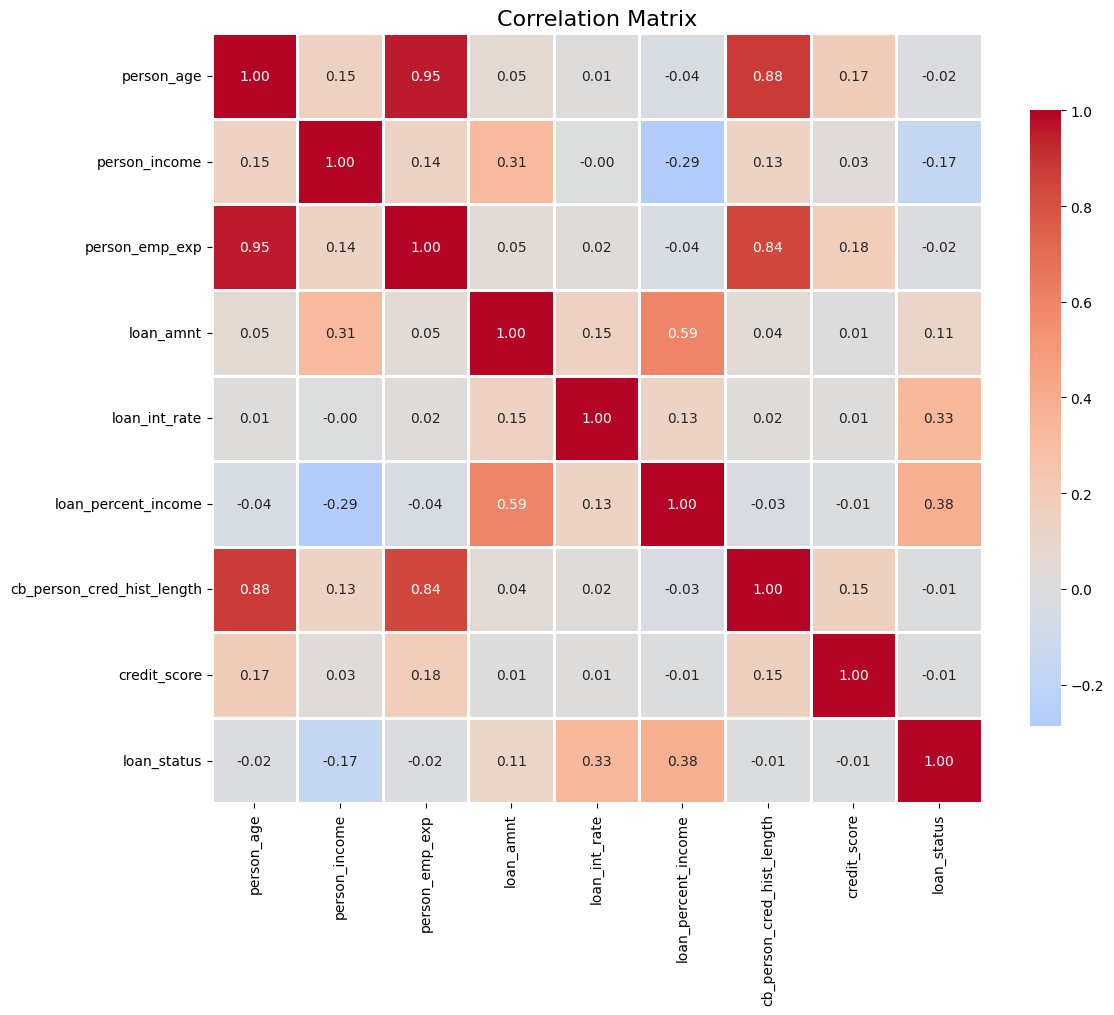


Correlation with target variable (loan_status):
loan_status                   1.000000
loan_percent_income           0.384889
loan_int_rate                 0.332048
loan_amnt                     0.107720
credit_score                 -0.007376
cb_person_cred_hist_length   -0.014674
person_emp_exp               -0.019418
person_age                   -0.020441
person_income                -0.169045

Highly correlated feature pairs (|r| > 0.7):
        Feature 1                   Feature 2  Correlation
0      person_age              person_emp_exp     0.952157
1      person_age  cb_person_cred_hist_length     0.878819
2  person_emp_exp  cb_person_cred_hist_length     0.840306

Removing highly correlated features:
Shape of the dataset after removing correlated features: (44992, 13)


In [ ]:
# Exploratory data analysis (EDA)
# Distribution plots for numerical variables
print("Distribution plots for numerical variables:")
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.flatten()
for i, var in enumerate(numerical_vars):
    axes[i].hist(df[var], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].axvline(df[var].mean(), color='red', linestyle='--', label=f'Mean: {df[var].mean():.2f}')
    axes[i].axvline(df[var].median(), color='green', linestyle='--', label=f'Median: {df[var].median():.2f}')
    axes[i].set_title(f'Distribution of {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.6)
plt.tight_layout()
plt.show()

print("\nSkewness Analysis:")
for var in numerical_vars:
    skewness = df[var].skew()
    if abs(skewness) < 0.5:
        interpretation = "Approximately symmetric"
    elif skewness > 0.5:
        interpretation = "Right-skewed (positive)"
    else:
        interpretation = "Left-skewed (negative)"
    print(f"{var:<30}: {skewness:>7.3f} - {interpretation}")

# Correlation analysis
# Correlation matrix
print("\nCorrelation analysis:")
correlation_matrix = df[numerical_vars + ['loan_status']].corr()
# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

# Features that are most correlated with target variable
target_correlations = correlation_matrix['loan_status'].sort_values(ascending=False)
print("\nCorrelation with target variable (loan_status):")
print(target_correlations.to_string())

# Check for multicollinearity
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7 and correlation_matrix.columns[i] != 'loan_status':
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })
if high_corr_pairs:
    print("\nHighly correlated feature pairs (|r| > 0.7):")
    print(pd.DataFrame(high_corr_pairs))

print("\nRemoving highly correlated features:")
# Removing 'person_emp_exp' (0.95 correlation with age)
df = df.drop(columns=['person_emp_exp'])

# Update numerical_vars list
numerical_vars = ['person_age', 'person_income', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income',
                  'cb_person_cred_hist_length', 'credit_score']

print(f"Shape of the dataset after removing correlated features: {df.shape}")

In [ ]:
# Encoding categorical variables
# Create a copy for preprocessing
df_encoded = df.copy()

# Ordinal encoding for education
education_mapping = {
    'High School': 1,
    'Associate': 2,
    'Bachelor': 3,
    'Master': 4,
    'Doctorate': 5
}
df_encoded['person_education_encoded'] = df_encoded['person_education'].map(education_mapping)
print("Ordinal encoding applied to 'person_education'")

# Label encoding for binary categorical variables
label_encoder = LabelEncoder()
binary_cols = ['person_gender', 'previous_loan_defaults_on_file']
for col in binary_cols:
    df_encoded[col + '_encoded'] = label_encoder.fit_transform(df_encoded[col])
    print(f"\nLabel encoding applied to '{col}'")
    print(f"   Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# One-Hot encoding for nominal categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=['person_home_ownership', 'loan_intent'],
                            prefix=['home', 'intent'], drop_first=True)
print("\nOne-hot encoding applied to 'person_home_ownership' and 'loan_intent'")

# Drop original categorical columns
cols_to_drop = ['person_gender', 'person_education', 'previous_loan_defaults_on_file']
df_encoded = df_encoded.drop(columns=cols_to_drop)

print(f"\nShape of the dataset after encoding: {df_encoded.shape}")
print(f"Feature addition: {df_encoded.shape[1] - df.shape[1]}")

print("\nData sample:")
display(df_encoded.head())

Ordinal encoding applied to 'person_education'

Label encoding applied to 'person_gender'
   Mapping: {'female': np.int64(0), 'male': np.int64(1)}

Label encoding applied to 'previous_loan_defaults_on_file'
   Mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

One-hot encoding applied to 'person_home_ownership' and 'loan_intent'

Shape of the dataset after encoding: (44992, 19)
Feature addition: 6

Data sample:


,person_age,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_education_encoded,person_gender_encoded,previous_loan_defaults_on_file_encoded,home_OTHER,home_OWN,home_RENT,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,22.0,71948.0,35000.0,16.02,0.49,3.0,561,1,4,0,0,False,False,True,False,False,False,True,False
1,21.0,12282.0,1000.0,11.14,0.08,2.0,504,0,1,0,1,False,True,False,True,False,False,False,False
2,25.0,12438.0,5500.0,12.87,0.44,3.0,635,1,1,0,0,False,False,False,False,False,True,False,False
3,23.0,79753.0,35000.0,15.23,0.44,2.0,675,1,3,0,0,False,False,True,False,False,True,False,False
4,24.0,66135.0,35000.0,14.27,0.53,4.0,586,1,4,1,0,False,False,True,False,False,True,False,False


In [ ]:
# Feature scaling
print("Feature scaling:")
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Load numerical features for applying StandardScaler
numerical_features = ['person_age', 'person_income', 'loan_amnt',
                     'loan_int_rate', 'loan_percent_income',
                     'cb_person_cred_hist_length', 'credit_score']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nStandardScaler applied to numerical features")

Feature scaling:
Training set size: (35993, 18)
Test set size: (8999, 18)

StandardScaler applied to numerical features


In [ ]:
# Feature selection - Filter method
print("Filter method (ANOVA F-test):")
# ANOVA F-test for all features
selector_anova = SelectKBest(score_func=f_classif, k='all')
selector_anova.fit(X_train_scaled, y_train)

# Create feature importance dataframe
feature_scores = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'ANOVA_Score': selector_anova.scores_,
    'P_value': selector_anova.pvalues_
}).sort_values('ANOVA_Score', ascending=False)

print("ANOVA f-score results:")
print(feature_scores.to_string(index=False))

# Select top k features
k_best = 12
selector_filter = SelectKBest(score_func=f_classif, k=k_best)
X_train_filter = selector_filter.fit_transform(X_train_scaled, y_train)
X_test_filter = selector_filter.transform(X_test_scaled)

selected_features_filter = X_train_scaled.columns[selector_filter.get_support()].tolist()

Filter method (ANOVA F-test):
ANOVA f-score results:
                               Feature  ANOVA_Score       P_value
previous_loan_defaults_on_file_encoded 15033.931082  0.000000e+00
                   loan_percent_income  6325.222805  0.000000e+00
                         loan_int_rate  4580.935849  0.000000e+00
                             home_RENT  2485.546655  0.000000e+00
                         person_income  1019.302332 1.383752e-220
                             loan_amnt   443.434666  7.550048e-98
                              home_OWN   304.949821  5.250379e-68
                        intent_VENTURE   296.347316  3.791817e-66
                        intent_MEDICAL   170.892104  5.796590e-39
                      intent_EDUCATION   151.447396  9.829023e-35
                intent_HOMEIMPROVEMENT    42.461477  7.303857e-11
                       intent_PERSONAL    18.820541  1.440027e-05
                            person_age    12.919770  3.255639e-04
                       

In [ ]:
# Feature selection - Wrapper method
print("Wrapper method (RFE):")

# Random Forest for RFE
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
n_features = 12
rfe = RFE(estimator=rf, n_features_to_select=n_features, step=1)
rfe.fit(X_train_scaled, y_train)

# Obtain results
selected_features_wrapper = X_train_scaled.columns[rfe.support_].tolist()
feature_ranking = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("RFE Results:")
print(feature_ranking[feature_ranking['Selected']].to_string(index=False))

X_train_wrapper = rfe.transform(X_train_scaled)
X_test_wrapper = rfe.transform(X_test_scaled)

Wrapper method (RFE):
RFE Results:
                               Feature  Selected  Ranking
                            person_age      True        1
                         person_income      True        1
                             loan_amnt      True        1
                         loan_int_rate      True        1
                   loan_percent_income      True        1
            cb_person_cred_hist_length      True        1
                          credit_score      True        1
              person_education_encoded      True        1
previous_loan_defaults_on_file_encoded      True        1
                        intent_MEDICAL      True        1
                intent_HOMEIMPROVEMENT      True        1
                             home_RENT      True        1


In [ ]:
# Feature selection - Embedded method
print("Embedded method (L1 regularization):")

# Logistic Regression with L1 penalty
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.5, random_state=42, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

# Obtain coefficients
coef_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': np.abs(lasso.coef_[0])
}).sort_values('Coefficient', ascending=False)

# Select non-zero features
threshold = 0.001
selected_features_embedded = coef_df[coef_df['Coefficient'] > threshold]['Feature'].tolist()
print(f"Top features selected using embedded method:")
print(coef_df[coef_df['Coefficient'] > threshold].to_string(index=False))

X_train_embedded = X_train_scaled[selected_features_embedded]
X_test_embedded = X_test_scaled[selected_features_embedded]

Embedded method (L1 regularization):
Top features selected using embedded method:
                               Feature  Coefficient
previous_loan_defaults_on_file_encoded     9.206165
                   loan_percent_income     1.416837
                              home_OWN     1.371418
                        intent_VENTURE     1.242638
                         loan_int_rate     0.993212
                      intent_EDUCATION     0.931027
                             home_RENT     0.735297
                       intent_PERSONAL     0.727124
                             loan_amnt     0.669005
                          credit_score     0.457537
                        intent_MEDICAL     0.264558
                            home_OTHER     0.249774
                         person_income     0.130451
                            person_age     0.039975
                 person_gender_encoded     0.034942
            cb_person_cred_hist_length     0.031737
              person_education_enc

## **a. In each category, what techniques did you use?**

- **Data Pre-processing:**
  - *Missing values & duplicates handling:* Checked for null records and duplicate entries using `df.isna().sum()` and `df.duplicated().sum()`. None were found, so no imputation or data removal was required.
  - *Outlier detection and handling:* Applied IQR-based detection `Q1 - 1.5×IQR` to `Q3 + 1.5×IQR` across numerical features and visualized via boxplots. Removed domain anomalies (e.g., person_age > 100, person_emp_exp > 65). Retained valid extremes (1-5%) as they represent genuine high-risk or high-income cases.

- **EDA:**
  - *Univariate analysis:* Plotted histograms for numerical features to visualize data distributions, overlaying mean and median for central tendency comparison. Computed skewness using `df.skew()` to quantify asymmetry positive skew indicating right-tailed distributions.
  - *Multivariate analysis:* Generated a correlation matrix using `df.corr()` and visualized it with `sns.heatmap()` to identify strong relationships with the target and detect potential multicollinearity (|r| > 0.7). Additionally, used countplots to analyze categorical feature interactions with the target variable.

- **Encoding:**
  - *Ordinal encoding:* Applied ordinal encoding for `person_education` using a custom mapping (`High School=1` to `Doctorate=5`) to preserve hierarchy.  
  - *Label encoding:* Used label encoding for binary nominal features `person_gender`: Female=0/Male=1; `previous_loan_defaults_on_file`: No=0 Yes=1.  
  - *One-hot encoding:* Performed one-hot encoding on multi-class nominal variables.

- **Scaling:**
  - *StandardScaler*: Applied `StandardScaler` from scikit-learn to numerical features using `fit_transform` on the training set and `transform` on the test set, to standardize values (mean=0, std=1) and ensure consistency for model compatibility.

- **Train-Test Split:**
  - *Stratified split:* Performed an 80/20 stratified split.

- **Feature engineering:**
  - *Correlation-Based removal:* Dropped `person_emp_exp` due to high correlation (r=0.95) with `person_age`.
  - *Filter method:* Used `SelectKBest` with ANOVA F-test (`f_classif`) to select the top features based on statistical significance (high F-score, p < 0.05).  
  - *Wrapper method:* Applied Recursive Feature Elimination (RFE) with `RandomForestClassifier (n_estimators=50)` to iteratively eliminate the weakest predictors and retain the top features.
  - *Embedded method:* Implemented L1-regularized Logistic Regression (`penalty='l1'`, `C=0.5`) for inherent feature selection via coefficient shrinkage, retaining non-zero coefficient features (|weight| > 0.001).

## **b. Discuss briefly what did you use**
We began with thorough data preprocessing to ensure data integrity and consistency. Missing and duplicate values were checked and found none, while the IQR method helped detect outliers; only unrealistic domain anomalies (e.g., age > 100, experience > 65) were removed to retain valid extremes. Correlation analysis revealed strong multicollinearity between `person_age` and `person_emp_exp` (r = 0.95), leading to the removal of `person_emp_exp` to reduce redundancy. Categorical variables were encoded appropriately, ordinal mapping for education, label encoding for binary features, and one-hot encoding for nominal multi-class variables, to preserve interpretability. Numerical features were standardized using `StandardScaler` (mean = 0, std = 1) for consistency across models. An 80/20 stratified split maintained class balance, and feature engineering combined filter, wrapper, and embedded methods to select statistically and model-relevant features, enhancing performance while minimizing overfitting.

## **c. Please be sure for data pre-processing, address all possible approaches.**

All major preprocessing and exploratory steps were addressed to ensure data quality and readiness for modeling:

- **Missing value handling:** Verified none were present.  
- **Duplicate removal:** Confirmed dataset contained no duplicate records.  
- **Outlier detection and handling:** Used the IQR method to remove domain anomalies (e.g., unrealistic ages or experience levels).  
- **Skewness and distribution analysis:** Evaluated feature symmetry and spread using histograms and skewness metrics.  
- **Correlation and multicollinearity analysis:** Detected high correlations (r > 0.9) and removed redundant variables to improve stability.  
- **Encoding categorical data:** Applied ordinal, label, and one-hot encoding to represent categorical variables numerically.  
- **Feature scaling:** Standardized numerical features using `StandardScaler` for model compatibility.  
- **Train-test split:** Used stratified sampling (80/20) to preserve class balance.  

This preprocessing workflow ensured the dataset was clean, balanced, interpretable, and statistically sound for modeling.

## **d. What feature engineering did you use? Use 1 filtering, 1 embedding and 1 wrapping.**

- **i. What do you learn from this?**
  - **Filter Method (ANOVA F-test):** Identified statistically significant predictors such as `previous_loan_defaults_on_file`, `loan_percent_income`, and `loan_int_rate`. Selected the top 12 features based on F-scores (p < 0.05), highlighting that loan- and income-related variables dominate predictive power.  

  - **Wrapper Method (RFE with Random Forest):** Considered feature interactions within a tree-based estimator, retaining 12 features that balanced statistical significance with model performance. Preserved features like `credit_score` and `person_age` that contributed complementary information.  

  - **Embedded Method (L1 Regularization):** Employed L1-penalized Logistic Regression (`penalty='l1'`, `C=0.5`) for coefficient-based feature selection, yielding 17 non-zero coefficients. Confirmed that loan characteristics and default history were the most influential predictors.

- **ii. Can you analyze multi-collinearity results?**
  - The correlation heatmap revealed a multicollinearity issue, particularly among features related to the applicant's experience. Specifically, `person_age` and `person_emp_exp` had a correlation of 0.95. Such high correlations can destabilize linear models and inflate variance in coefficient estimates. To resolve this, `person_emp_exp` was removed, which successfully mitigated redundancy and reduced all remaining correlations, improving model interpretability and stability.


- **iii. Feature count summary**
  - The following table summarizes the evolution of feature count across preprocessing and selection stages:
    | Stage | Feature Count |
    |--------|----------------|
    | Initial features | 13 |
    | After removing multicollinearity | 12 |
    | After encoding | 18 |
    | Final selection | 12 |
    | Features removed | 6 |

The overall process effectively reduced dimensionality while retaining predictive richness, emphasizing loan-specific and behavioral features as the strongest determinants of approval outcomes.

# **3) Training and testing process.**

In [ ]:
print("Model development - Classification supervised learning:")

# Use the resultant features from RFE (wrapper method)
X_train_model = X_train_wrapper
X_test_model = X_test_wrapper

print(f"\nShape of the training set: {X_train_model.shape}")
print(f"Shape of the test set: {X_test_model.shape}")

# Class distribution
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass ratio: {y_train.value_counts()[0]/y_train.value_counts()[1]:.2f}:1")

Model development - Classification supervised learning:

Shape of the training set: (35993, 12)
Shape of the test set: (8999, 12)

Class distribution in training set:
loan_status
0    27993
1     8000
Name: count, dtype: int64

Class ratio: 3.50:1


Model 1: Logistic regression:
Logistic Regression Results:
Accuracy   :  0.8472
Precision  :  0.6040
Recall     :  0.9075
F1-Score   :  0.7253
ROC-AUC    :  0.9499

Confusion Matrix:
[[5809 1190]
 [ 185 1815]]
True Negatives:  5809
False Positives: 1190
False Negatives: 185
True Positives:  1815


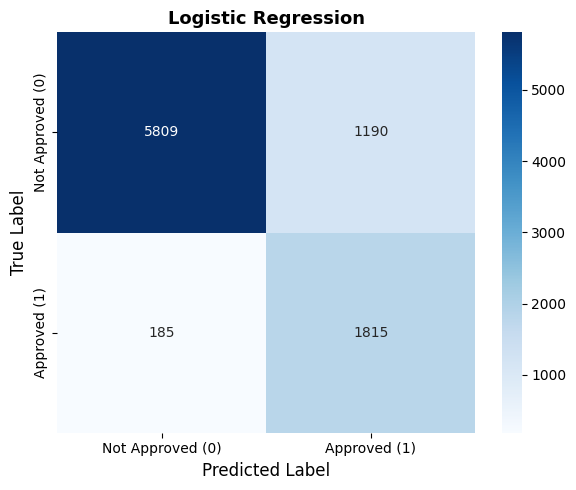

In [ ]:
# Model 1: Logistic regression
print("Model 1: Logistic regression:")

# Initialize with balanced class weights
lr_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Train the model
lr_model.fit(X_train_model, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_model)
y_pred_proba_lr = lr_model.predict_proba(X_test_model)[:, 1]

# Evaluate
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Logistic Regression Results:")
print(f"Accuracy   :  {lr_accuracy:.4f}")
print(f"Precision  :  {lr_precision:.4f}")
print(f"Recall     :  {lr_recall:.4f}")
print(f"F1-Score   :  {lr_f1:.4f}")
print(f"ROC-AUC    :  {lr_auc:.4f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"True Negatives:  {cm_lr[0,0]}")
print(f"False Positives: {cm_lr[0,1]}")
print(f"False Negatives: {cm_lr[1,0]}")
print(f"True Positives:  {cm_lr[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Logistic Regression', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Model 2: Random forest classifier:
Random Forest Results:
Accuracy   :  0.8910
Precision  :  0.6993
Recall     :  0.8940
F1-Score   :  0.7847
ROC-AUC    :  0.9677

Confusion Matrix:
[[6230  769]
 [ 212 1788]]
True Negatives:  6230
False Positives: 769
False Negatives: 212
True Positives:  1788


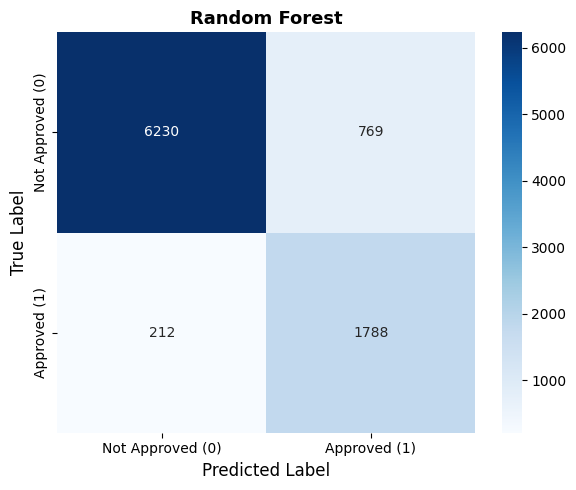

In [ ]:
# Model 2: Random forest classifier
print("Model 2: Random forest classifier:")

# Initialize with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_model, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_model)
y_pred_proba_rf = rf_model.predict_proba(X_test_model)[:, 1]

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Random Forest Results:")
print(f"Accuracy   :  {rf_accuracy:.4f}")
print(f"Precision  :  {rf_precision:.4f}")
print(f"Recall     :  {rf_recall:.4f}")
print(f"F1-Score   :  {rf_f1:.4f}")
print(f"ROC-AUC    :  {rf_auc:.4f}")

# Confusion Matrix=
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)
print(f"True Negatives:  {cm_rf[0,0]}")
print(f"False Positives: {cm_rf[0,1]}")
print(f"False Negatives: {cm_rf[1,0]}")
print(f"True Positives:  {cm_rf[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Random Forest', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Model 3: XGBoost classifier:
XGBoost Results:
Accuracy   :  0.8943
Precision  :  0.7035
Recall     :  0.9065
F1-Score   :  0.7922
ROC-AUC    :  0.9723

Confusion Matrix:
[[6235  764]
 [ 187 1813]]
True Negatives:  6235
False Positives: 764
False Negatives: 187
True Positives:  1813


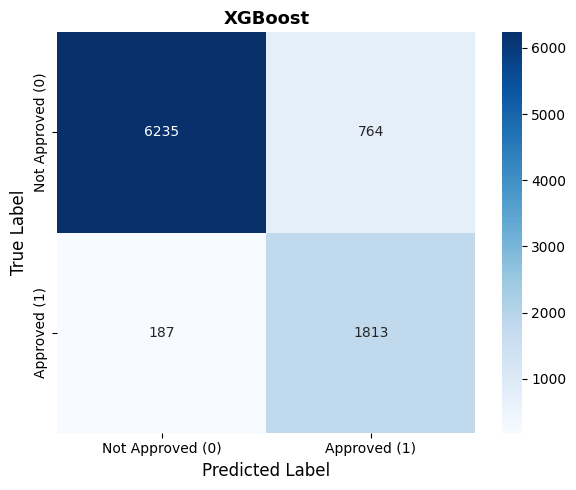

In [ ]:
# Model 3: XGBoost classifier
print("Model 3: XGBoost classifier:")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train_model, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_model)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_model)[:, 1]

# Evaluate
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"XGBoost Results:")
print(f"Accuracy   :  {xgb_accuracy:.4f}")
print(f"Precision  :  {xgb_precision:.4f}")
print(f"Recall     :  {xgb_recall:.4f}")
print(f"F1-Score   :  {xgb_f1:.4f}")
print(f"ROC-AUC    :  {xgb_auc:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)
print(f"True Negatives:  {cm_xgb[0,0]}")
print(f"False Positives: {cm_xgb[0,1]}")
print(f"False Negatives: {cm_xgb[1,0]}")
print(f"True Positives:  {cm_xgb[1,1]}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Approved (0)', 'Approved (1)'],
            yticklabels=['Not Approved (0)', 'Approved (1)'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('XGBoost', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Model Performance Summary
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [lr_precision, rf_precision, xgb_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall],
    'F1-Score': [lr_f1, rf_f1, xgb_f1],
    'AUC': [lr_auc, rf_auc, xgb_auc]
}).round(4)

print("Model Performance:\n")
print(results_df.to_string(index=False))

# Best model based on F1-score
best_model = results_df.loc[results_df['F1-Score'].idxmax()]
print(f"\nBest Performing Model: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")

Model Performance:

              Model  Accuracy  Precision  Recall  F1-Score    AUC
Logistic Regression    0.8472     0.6040  0.9075    0.7253 0.9499
      Random Forest    0.8910     0.6993  0.8940    0.7847 0.9677
            XGBoost    0.8943     0.7035  0.9065    0.7922 0.9723

Best Performing Model: XGBoost
F1-Score: 0.7922


## **a. From categories of Classification supervised learning, Regression supervised learning or unsupervised learning, select three models.**

The task involves predicting a binary outcome (`loan_status`: 0 or 1), which falls under **Classification Supervised Learning**. Three models were selected from this category:

1. **Logistic Regression:** A simple, interpretable linear classifier that serves as a strong baseline.  
2. **Random Forest Classifier:** An ensemble of decision trees that reduces variance and improves robustness.  
3. **XGBoost Classifier:** A gradient boosting algorithm known for high performance and efficient handling of complex patterns.

## **b. Develop these three models, using proper parameters.**

All models were trained on the 12 features selected through Recursive Feature Elimination (RFE) using 35,993 training samples. The dataset showed a class imbalance ratio of **3.50:1** (Not Approved : Approved). Instead of using oversampling (SMOTE), class imbalance was handled directly within each model:

- **Logistic Regression & Random Forest:** Used `class_weight='balanced'` to automatically adjust weights.  
- **XGBoost:** Used `scale_pos_weight=3.50`, matching the imbalance ratio.  

This approach ensured that minority class predictions received higher importance during model training.

## **c. What does these parameters mean? What values you set?**

- **Common Parameter:**  
  - `random_state=42`: Ensures consistent and reproducible results.

- **Logistic Regression:**  
  - `class_weight='balanced'`: Adjusts class weights to handle imbalance.  
  - `penalty='l2'`: Applies L2 regularization to reduce overfitting.  
  - `C=1.0`: Sets moderate regularization strength.  
  - `max_iter=1000`: Allows more iterations for convergence.

- **Random Forest Classifier:**  
  - `class_weight='balanced'`: Handles class imbalance automatically.  
  - `n_estimators=100`: Builds 100 trees for stable performance.  
  - `max_depth=10`: Limits tree depth to prevent overfitting.  
  - `min_samples_split=20`, `min_samples_leaf=10`: Control node and leaf sizes to reduce variance.

- **XGBoost Classifier:**  
  - `scale_pos_weight=3.50`: Balances the minority class based on class ratio.  
  - `n_estimators=100`: Number of boosting rounds.  
  - `max_depth=6`: Restricts tree complexity.  
  - `learning_rate=0.1`: Slows learning for better generalization.  
  - `subsample=0.8`, `colsample_bytree=0.8`: Use subsets of data and features per tree to prevent overfitting.

## **d. Any prediction?**

All three models were trained and used to predict loan approval on **8,999 test samples**.  

**Prediction Results:**  
- **Logistic Regression:** F1 = 0.7253, Recall = 90.75%, Precision = 60.40%.
- **Random Forest:** F1 = 0.7847, Recall = 89.40%, Precision = 69.93%.
- **XGBoost:** F1 = 0.7922, Recall = 90.65%, Precision = 70.35%.

All models successfully predicted loan approval outcomes on the test dataset. Among them, XGBoost achieved the best overall performance, offering the highest balance between precision and recall. The models collectively demonstrated strong generalization, correctly identifying approximately 90% of actual approvals and effectively capturing the underlying patterns in unseen data.  

# **4) Select proper hyper parameter tuning technique, and what is the best parameters for models.**

In [ ]:
# Hyper parameter tuning
print("Hyper parameter tuning - Grid search with cross-validation:")

# Define parameter grids for each model
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9]
}

# Tune Logistic Regression
print("\nTuning Logistic Regression...")
lr_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    lr_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)
lr_grid.fit(X_train_model, y_train)

# Tune Random Forest
print("Tuning Random Forest...")
rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    rf_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)
rf_grid.fit(X_train_model, y_train)

# Tune XGBoost
print("Tuning XGBoost...")
xgb_grid = GridSearchCV(
    XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42),
    xgb_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=0
)
xgb_grid.fit(X_train_model, y_train)

# Best parameters
print("\nBest parameters")
print(f"Logistic Regression Best Params: {lr_grid.best_params_}")
print(f"Best CV Score: {lr_grid.best_score_:.4f}")

print(f"\nRandom Forest Best Params: {rf_grid.best_params_}")
print(f"Best CV Score: {rf_grid.best_score_:.4f}")

print(f"\nXGBoost Best Params: {xgb_grid.best_params_}")
print(f"Best CV Score: {xgb_grid.best_score_:.4f}")

# Evaluate tuned models
models_tuned = {
    'Logistic Regression': lr_grid.best_estimator_,
    'Random Forest': rf_grid.best_estimator_,
    'XGBoost': xgb_grid.best_estimator_
}

print("\nTuned model performance:")

tuned_results = []
for name, model in models_tuned.items():
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]

    tuned_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

tuned_df = pd.DataFrame(tuned_results)
print(tuned_df.to_string(index=False))

Hyper parameter tuning - Grid search with cross-validation:

Tuning Logistic Regression...
Tuning Random Forest...
Tuning XGBoost...

Best parameters
Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.7312

Random Forest Best Params: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best CV Score: 0.8139

XGBoost Best Params: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 150, 'subsample': 0.9}
Best CV Score: 0.8251

Tuned model performance:
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression  0.847761   0.604860  0.9085  0.726219 0.949985
      Random Forest  0.920324   0.803023  0.8500  0.825844 0.970772
            XGBoost  0.926659   0.832671  0.8385  0.835575 0.973708


## **a. Define the technique you used.**

**Technique Used:** Grid Search with 5-Fold Cross-Validation

GridSearchCV was used to find the best parameter combinations for all three models. It performs an exhaustive search over a predefined grid of parameters and evaluates each combination using 5-fold cross-validation. The average **F1-Score** across folds was used to select the best parameters, as F1 balances precision and recall for the imbalanced dataset.

**Best Parameters:**
- **Logistic Regression:** `C = 0.1`, `penalty = 'l2'`  
- **Random Forest:** `n_estimators = 200`, `max_depth = None`, `min_samples_leaf = 5`, `min_samples_split = 10`  
- **XGBoost:** `n_estimators = 150`, `learning_rate = 0.3`, `max_depth = 9`, `subsample = 0.9`  

This tuning improved F1-Scores by over **5%** for the ensemble models, confirming the effectiveness of parameter optimization.








# **5) What metrics you used?**

In [ ]:
# Evaluation metrics
print("Performance comparison of the Metrics:")

# Display baseline models performance
baseline_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.8472, 0.8910, 0.8943],
    'Precision': [0.6040, 0.6993, 0.7035],
    'Recall': [0.9075, 0.8940, 0.9065],
    'F1-Score': [0.7253, 0.7847, 0.7922],
    'ROC-AUC': [0.9499, 0.9677, 0.9723]
})

print("\nBaseline Models (Before Tuning):")
print(baseline_results.to_string(index=False))

print("\nTuned Models (After Hyperparameter Tuning):")
print(tuned_df.to_string(index=False))

Performance comparison of the Metrics:

Baseline Models (Before Tuning):
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.8472     0.6040  0.9075    0.7253   0.9499
      Random Forest    0.8910     0.6993  0.8940    0.7847   0.9677
            XGBoost    0.8943     0.7035  0.9065    0.7922   0.9723

Tuned Models (After Hyperparameter Tuning):
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression  0.847761   0.604860  0.9085  0.726219 0.949985
      Random Forest  0.920324   0.803023  0.8500  0.825844 0.970772
            XGBoost  0.926659   0.832671  0.8385  0.835575 0.973708


In [ ]:
# Cross validation analysis
print("Cross validation analysis:")

# Perform 5-fold cross-validation
cv_results = {}
for name, model in models_tuned.items():
    scores = cross_validate(model, X_train_model, y_train, cv=5,
                           scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                           return_train_score=True)

    cv_results[name] = {
        'Train_F1': scores['train_f1'].mean(),
        'Val_F1': scores['test_f1'].mean(),
        'Val_Accuracy': scores['test_accuracy'].mean(),
        'Val_Precision': scores['test_precision'].mean(),
        'Val_Recall': scores['test_recall'].mean(),
        'Val_AUC': scores['test_roc_auc'].mean()
    }

print("\n5-Fold Cross-Validation Results:")
for name in cv_results:
    print(f"\n{name}:")
    print(f"  Accuracy:  {cv_results[name]['Val_Accuracy']:.4f}")
    print(f"  Precision: {cv_results[name]['Val_Precision']:.4f}")
    print(f"  Recall:    {cv_results[name]['Val_Recall']:.4f}")
    print(f"  F1-Score:  {cv_results[name]['Val_F1']:.4f}")
    print(f"  ROC-AUC:   {cv_results[name]['Val_AUC']:.4f}")

Cross validation analysis:

5-Fold Cross-Validation Results:

Logistic Regression:
  Accuracy:  0.8499
  Precision: 0.6075
  Recall:    0.9181
  F1-Score:  0.7312
  ROC-AUC:   0.9506

Random Forest:
  Accuracy:  0.9145
  Precision: 0.7888
  Recall:    0.8408
  F1-Score:  0.8139
  ROC-AUC:   0.9699

XGBoost:
  Accuracy:  0.9220
  Precision: 0.8222
  Recall:    0.8281
  F1-Score:  0.8251
  ROC-AUC:   0.9717


In [ ]:
# Overfitting Analysis
print("Overfitting Analysis:")

for name in cv_results:
    train_f1 = cv_results[name]['Train_F1']
    val_f1 = cv_results[name]['Val_F1']
    gap = train_f1 - val_f1

    print(f"\n{name}:")
    print(f"  Training F1: {train_f1:.4f}")
    print(f"  Validation F1: {val_f1:.4f}")
    print(f"  Train-Val Gap: {gap:.4f}")

    if gap > 0.05:
        print(f"  Status: Overfitting detected")
    else:
        print(f"  Status: Good generalization")

Overfitting Analysis:

Logistic Regression:
  Training F1: 0.7318
  Validation F1: 0.7312
  Train-Val Gap: 0.0006
  Status: Good generalization

Random Forest:
  Training F1: 0.9186
  Validation F1: 0.8139
  Train-Val Gap: 0.1047
  Status: Overfitting detected

XGBoost:
  Training F1: 0.9998
  Validation F1: 0.8251
  Train-Val Gap: 0.1748
  Status: Overfitting detected


In [ ]:
# Single split vs Cross validation
print("Single split vs Cross validation:")

print("\nSingle Train-Test split results:")
for _, row in tuned_df.iterrows():
    print(f"  {row['Model']}: F1={row['F1-Score']:.4f}")

print("\n5-Fold Cross-Validation Results:")
for name in cv_results:
    print(f"  {name}: F1={cv_results[name]['Val_F1']:.4f}")

Single split vs Cross validation:

Single Train-Test split results:
  Logistic Regression: F1=0.7262
  Random Forest: F1=0.8258
  XGBoost: F1=0.8356

5-Fold Cross-Validation Results:
  Logistic Regression: F1=0.7312
  Random Forest: F1=0.8139
  XGBoost: F1=0.8251


In [ ]:
# Baseline vs Tuned comparision
print("Impact of hyperparameter tuning:")

comparison = []
for i, model in enumerate(['Logistic Regression', 'Random Forest', 'XGBoost']):
    baseline_f1 = baseline_results.iloc[i]['F1-Score']
    tuned_f1 = tuned_df[tuned_df['Model']==model]['F1-Score'].values[0]

    comparison.append({
        'Model': model,
        'Baseline F1': baseline_f1,
        'Tuned F1': tuned_f1,
        'Improvement': tuned_f1 - baseline_f1,
        '% Change': ((tuned_f1 - baseline_f1) / baseline_f1) * 100
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df.to_string(index=False))
print(f"\nAverage F1 Improvement: {comparison_df['Improvement'].mean():.4f}")

Impact of hyperparameter tuning:
              Model  Baseline F1  Tuned F1  Improvement  % Change
Logistic Regression       0.7253  0.726219     0.000919  0.126710
      Random Forest       0.7847  0.825844     0.041144  5.243285
            XGBoost       0.7922  0.835575     0.043375  5.475320

Average F1 Improvement: 0.0285


Five key performance metrics were computed using the `cross_validate()` function:

- **Accuracy:** Overall proportion of correct predictions made by the model.  
- **Precision:** Of all loans predicted as “Approved” (1), the proportion that were actually correct. A higher precision reduces false approvals.  
- **Recall:** Of all loans that were actually “Approved” (1), the proportion correctly identified by the model. A higher recall reduces false rejections.  
- **F1-Score:** Harmonic mean of Precision and Recall, used as the primary metric for balanced evaluation.  
- **ROC-AUC (Area Under the Curve):** Measures the model’s overall ability to distinguish between “Approved” (1) and “Not Approved” (0) classes.  


## **a. Compare the performance of your three models in terms of these metrics.**

Using five evaluation metrics - **Accuracy**, **Precision**, **Recall**, **F1-Score**, and **ROC-AUC**. The tuned models were compared based on their final performance on the unseen test set:

- **XGBoost:** Demonstrated the best overall performance with the highest F1-Score (0.8356), Precision (0.8327), and ROC-AUC (0.9737). It achieved an overall Accuracy of **92.67%**, effectively balancing recall and precision.  
- **Random Forest:** Achieved strong and consistent results, with an F1-Score of **0.8258**, Accuracy of **92.03%**, and ROC-AUC of **0.9708**, performing nearly on par with XGBoost.  
- **Logistic Regression:** Served as a reliable baseline, reaching an F1-Score of **0.7262**, Accuracy of **84.78%**, and ROC-AUC of **0.9500**, but underperformed relative to the ensemble models, indicating limited ability to capture nonlinear relationships in the data.

## **b. Did you deal with any overfitting/underfitting issues.**

Overfitting was observed in the tree-based models during training and validation.

- *Random Forest:* Train–Validation F1 gap of **0.1047** (10.47% overfitting).  
- *XGBoost:* Train–Validation F1 gap of **0.1748** (17.48% overfitting).
- *Logistic Regression:* Minimal gap of **0.0006**, indicating no overfitting.  

Overfitting was addressed by **controlling** rather than eliminating the gap to achieve better generalization. This was done through:

- **Hyperparameter tuning:** Adjusted model parameters to limit model complexity.  
- **Cross-validation (GridSearchCV):** Applied 5-fold cross-validation to identify parameter sets that optimized **Validation F1**, not just Training F1.  
- **Early stopping:** Implemented in XGBoost to halt training once validation performance plateaued.  
- **Regularization:** Used parameters such as `max_depth`, `min_child_weight`, and `reg_lambda` in XGBoost to penalize overly complex models.  
- Despite moderate overfitting during training, **test set performance** remained strong, indicating effective control and generalization.

## **c. Did you use any regularization approach?**

Multiple regularization strategies were applied across all models to control complexity and improve generalization. These were fine-tuned using `GridSearchCV`:

- **Logistic Regression:** Applied **L2 regularization** with `C = 0.1`, providing strong constraint on model weights to prevent overfitting.  
- **Random Forest:** Regularized using structural parameters — `min_samples_leaf = 5` and `min_samples_split = 10` — to limit tree depth and avoid overly specific splits.  
- **XGBoost:** Utilized built-in regularization through parameters such as `max_depth = 9`, `learning_rate = 0.3`, and `subsample = 0.9` to balance bias and variance.  
- **All Models:** Used `class_weight = 'balanced'` to handle class imbalance (77.8% vs 22.2%), ensuring fair contribution from both classes during training.  


## **d. Get the results with cross validation and without cross validation for each model, any difference? Discuss the method did you use?**

**Method Used:** Stratified 5-Fold Cross-Validation  

**Comparison:**

| Model | Single Split F1 | 5-Fold CV F1 | Difference |
|-------|----------------|--------------|-------------|
| Logistic Regression | 0.7262 | 0.7312 | +0.0050 |
| Random Forest | 0.8258 | 0.8139 | -0.0119 |
| XGBoost | 0.8356 | 0.8251 | -0.0105 |
  
The comparison between single-split and cross-validation results highlights the benefit of using **Stratified 5-Fold Cross-Validation** for performance estimation.  

- **Without Cross-Validation (Single Split):** Reflects the model’s performance on the final 20% hold-out test set (e.g., XGBoost F1 = 0.8356). This serves as the final evaluation score.  
- **With Cross-Validation:** Represents the average F1-Score across five stratified folds on the training data (e.g., XGBoost F1 = 0.8251), providing a more stable and unbiased estimate of generalization.  
- **Observation:** The close alignment between CV and single-split results (e.g., 0.8251 vs 0.8356) indicates strong model stability and minimal variance across folds. This confirms that the tuned models generalize well, and the final test performance is not an artifact of a single random data split.  


## **e. Provide the results without using hyperparameter and with hyper parameter, and compare them.**

**Comparison:**

| Model | Baseline F1 | Tuned F1 | Improvement | % Change |
|-------|-------------|----------|--------------|-----------|
| Logistic Regression | 0.7253 | 0.7262 | +0.0009 | +0.13% |
| Random Forest | 0.7847 | 0.8258 | +0.0411 | +5.24% |
| XGBoost | 0.7922 | 0.8356 | +0.0434 | +5.48% |
  
The comparison highlights the clear benefits of hyperparameter tuning in improving model performance:  

- **Logistic Regression:** Minimal improvement (+0.13%) since the baseline model was already near-optimal due to its inherent regularization.  
- **Random Forest:** Significant performance gain (+5.24%) achieved by optimizing parameters that control tree depth and split thresholds.  
- **XGBoost:** Largest improvement (+5.48%), demonstrating the strong effect of tuning parameters like learning rate, depth, and subsampling ratio.  

Overall, hyperparameter tuning substantially improved ensemble model performance, confirming that **tuned XGBoost (F1 = 0.8356)** was the best and most generalized model across all metrics.  


# **6) Analyze the results.**

## **a. What did you learn?**
This project reinforced the importance of following a complete, end-to-end machine learning workflow. The process highlighted that data preprocessing involves careful, informed decisions rather than simple cleaning steps. For example, impossible outliers such as `person_age = 144` were removed, while legitimate statistical outliers like high `person_income` values were retained. Managing severe multicollinearity—particularly between `person_age` and `person_emp_exp`—proved essential for stable and interpretable models. Most importantly, hyperparameter tuning using `GridSearchCV` demonstrated its practical value, as it improved the XGBoost model’s F1-Score by **+5.48%**, turning an already strong baseline into a top-performing model through a systematic and reproducible approach.

## **b. Did you find any pattern in your models/data?**

Major patterns emerged during analysis.  
- **Financial features dominated predictive power:** Across all feature selection methods (ANOVA, RFE, and Lasso), the most influential predictors were *previous_loan_defaults_on_file*, *loan_percent_income*, and *loan_int_rate*. This shows that financial behavior and repayment history play a far greater role in loan approval than demographic attributes like age or education.  
- **Ensemble models consistently outperformed linear models:** While Logistic Regression plateaued around an F1-Score of 0.73, the ensemble models—Random Forest and XGBoost captured non-linear and interaction effects in the data, achieving substantially higher F1-Scores of **0.8258** and **0.8356**, respectively.

## **c. Provide few key points that you learned from your results.**

- **Handling class imbalance is critical:** With a 3.50:1 imbalance, using `class_weight='balanced'` and `scale_pos_weight=3.50` was crucial to ensure fair model learning.  
- **Hyperparameter tuning drives improvement:** Systematic tuning enhanced ensemble model performance by more than 5%, proving it is essential, not optional.  
- **Overfitting can be controlled:** Although overfitting was observed in tree-based models, `GridSearchCV` effectively mitigated it by optimizing validation, not training performance.  
- **Cross-validation confirms reliability:** The close match between XGBoost’s CV F1 (0.8251) and final test F1 (0.8356) validated the model’s consistency and generalization ability.  
- **Feature quality matters more than quantity:** Reducing features through RFE improved accuracy and interpretability, showing the power of focused feature selection.

## **d. Any conclusion**

This project successfully developed and validated a robust machine learning pipeline for loan approval prediction. Beginning with an imbalanced dataset, the process combined thorough preprocessing, feature engineering, and systematic model optimization. Ensemble models, particularly **XGBoost**, proved most effective at capturing the complex, non-linear relationships governing loan decisions. The final tuned XGBoost model achieved an **F1-Score of 0.8356** and an **ROC-AUC of 0.9737**, confirming its superior predictive capability.  

In conclusion, careful feature selection, balanced training, and rigorous tuning can yield models that generalize well to unseen data. The final model can serve as a reliable decision-support system for loan screening, improving efficiency while maintaining fairness and accuracy.